In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
import alpaca_trade_api as tradeapi
import numpy as np
import itertools
import sklearn
import keras
import time
import shap
import tensorflow as tf

from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc


print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

%matplotlib inline

ModuleNotFoundError: No module named 'shap'

In [2]:
# Class Object to measure time
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self


#### Download BTC data and create BTC dataframe.

In [3]:
# Load the data into a Pandas DataFrame
BTC_df = pd.read_csv(
    Path('../Resources/BTC_data.csv'),
    index_col="Date")
BTC_df.drop(['Adj Close','Volume'], axis=1, inplace=True)
BTC_df.tail()

,Open,High,Low,Close
Date,,,,
2021-11-12,64863.980469,65460.816406,62333.914062,64155.941406
2021-11-13,64158.121094,64915.675781,63303.734375,64469.527344
2021-11-14,64455.371094,65495.179688,63647.808594,65466.839844
2021-11-15,65521.289062,66281.570312,63548.144531,63557.871094
2021-11-16,63190.082031,63190.082031,59083.867188,60715.683594


# Visualize the actual OHLC candlestick chart.
by using matplotlib library with finnance extension called mpl_finance

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


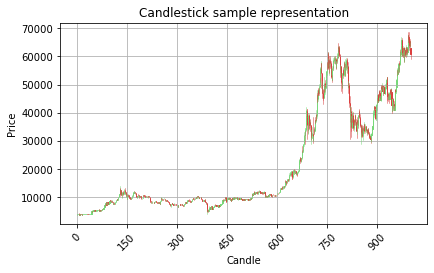

In [4]:
# Plot OHLC candlestick data in to chart
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

# Visualize 1000 candlesticks on the OHLC chart in one time
graph_data_ohlc(BTC_df.tail(1000).values)


#### Converting data to time series format.

In [5]:
# Custom generator function to create 3d arrays of candles sequence
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(BTC_df.values[1:],3))
cell_timer.kill()

# Check the shape of 3 dimension array
three_dim_sequence.shape

Time elapsed: 00:00:00


(2611, 3, 4)

Step 1


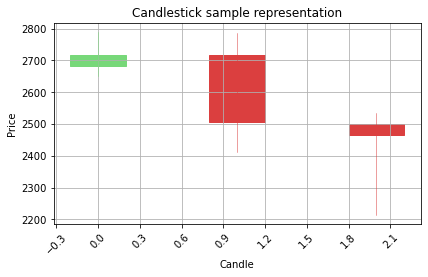

Step 2


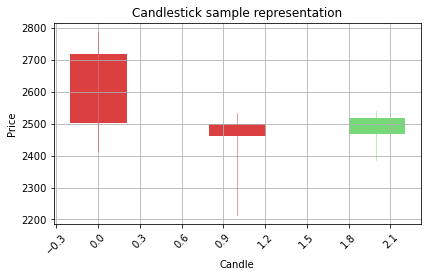

Step 3


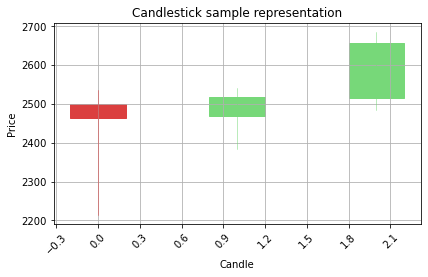

Step 4


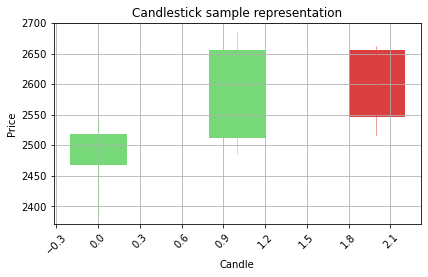

Step 5


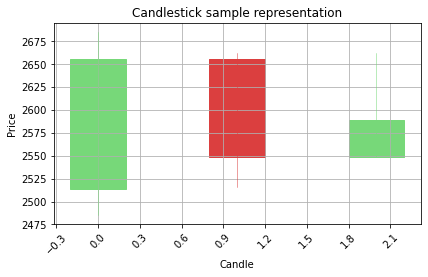

In [6]:
# Visualize the step by step sequency of price movements on the OHLC chart
counter=0
for candle in three_dim_sequence[1000:1005]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)


#### Convert the price data in to actual candlestick parameters

In [7]:
# Convert OHLC data in to candlestick parameters data
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)

    return candlestick_data


#### Apply this function in to generator function to get sequences with candlestick data instead of OHLC data

In [8]:
# Generator function to get sequences with candlestick data instead of OHLC data
def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

# Get data in form of sequences made from last 3 candles
three_dim_sequence_candle=my_generator_candle(BTC_df.values[1:],3)

# Check conversion data
three_dim_sequence_candle[5000:5005]



array([], shape=(0, 3, 4), dtype=float64)

# Generate forecasting data

In [9]:
# Update of the generator to return one more array with 1 or 0 (Bullish or Bearish)
def my_generator_candle_X_Y(data,lookback,MinMax = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)

        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:
            arr = np.append(arr, templist4, axis=0)

        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)

        first_row=first_row+1

    arr2 = np.asarray(Y_list)

    return arr,arr2,arr3


#### Define data set
* X = Input dataset on which our neural network will make predictions
* Y = Prediction dataset (results of the correct predictions)

In [10]:
# Define X, Y variables
cell_timer = MeasureTime()
X,Y, X_raw = my_generator_candle_X_Y(BTC_df.values,3,MinMax=False)
cell_timer.kill()


# Exploring the generated dataset
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

display(X[100])
display(Y[100])
display(X_raw[100])


Time elapsed: 00:00:00
Shape of X (2611, 3, 4)
Shape of Y (2611,)
Shape of X raw ohlc (2611, 3, 4)


array([[1.00000e+00, 3.50000e+04, 2.52499e+04, 8.77200e+04],
       [0.00000e+00, 1.32800e+04, 3.23300e+04, 1.30480e+05],
       [1.00000e+00, 2.78900e+04, 5.08200e+04, 1.07901e+04]])

0

array([[319.15200806, 331.42401123, 316.62701416, 327.92401123],
       [327.58300781, 328.91101074, 312.63000488, 315.86300659],
       [316.16000366, 320.02801514, 311.07800293, 317.23901367]])

In [11]:
# Bullish and bearish predictions count
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 1415 percent: 54.19%
Bear: 1196 percent: 45.81%
Total: 2611


Correct prediction would be Bullish ---^


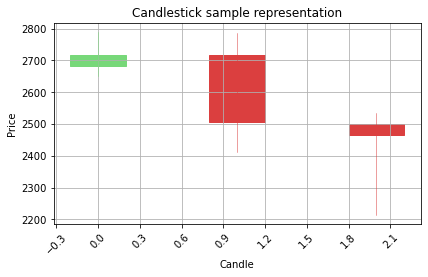

Correct prediction would be Bullish ---^


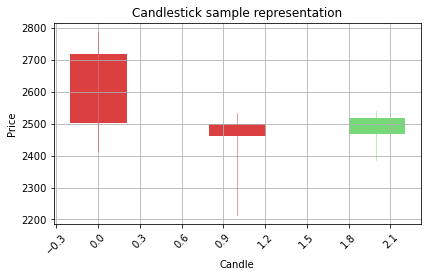

Correct prediction would be Bearish ---v


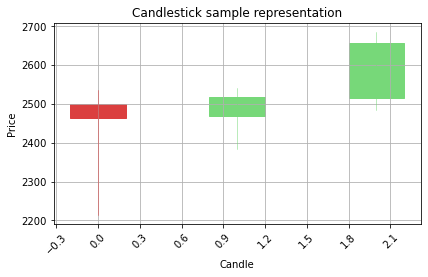

Correct prediction would be Bullish ---^


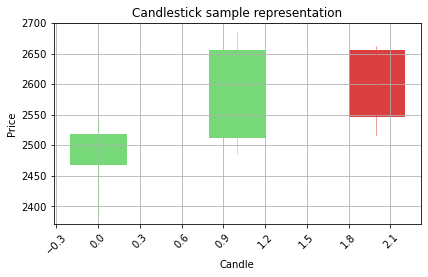

Correct prediction would be Bullish ---^


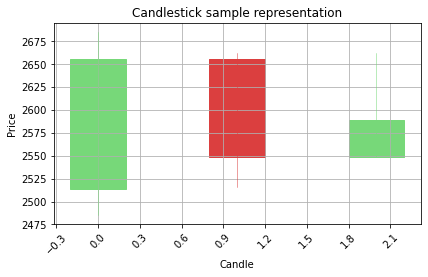

In [12]:
# Visualize the candle sequence
for a in range(5):
    b=a+1000
    if Y[b] == 1:print('Correct prediction would be Bullish ---^')
    if Y[b] == 0:print('Correct prediction would be Bearish ---v')
    graph_data_ohlc(X_raw[b])


## Build Deep Learning model 

#### Defining the model using LSTM network ( Long-Term Short-Term)

In [13]:
# Defining the model
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam


model = Sequential()
model.add(layers.CuDNNLSTM(units = 12,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(layers.CuDNNLSTM(units = 24))
model.add(layers.Dense(units = 1,activation='sigmoid'))


In [14]:
# Complile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, None, 12)          864       
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 24)                3648      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 4,537
Trainable params: 4,537
Non-trainable params: 0
_________________________________________________________________


#### Train the deep learning model
Split data for 3 parts:
* Traning dataset
* Validation dataset
* Test dataset


In [16]:
# Split data
cell_timer = MeasureTime()
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw= train_test_split(X_raw, test_size=0.5)
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5)
cell_timer.kill()

# Train model 13 times with 500 training dataset
cell_timer = MeasureTime()
history = model.fit(X_train, Y_train,batch_size=500, epochs=13,validation_data=(X_val, Y_val))
cell_timer.kill()



Time elapsed: 00:00:00
Epoch 1/13


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential/cu_dnnlstm/CudnnRNNV2}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[sequential/cu_dnnlstm/CudnnRNNV2]] [Op:__inference_train_function_2527]

#### model training loss and validation loss

In [16]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Test the model against new data
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

#### Visualize the predictions on the candlestick charts to see the patterns

In [ ]:
# Filter out the low confidence predictions from the model by using the alpha distance variable. 
# If the prediction value is close to 0, that means the prediction is 0
# If the predicted value is closer to 1, the model predicted the value 1. 
# If the prediction value is closer to its target, the confidence of the prediction is biger. 
# Less distance to target prediction value, better the confidence.
cell_timer = MeasureTime()
counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

for a in test:
    #print(a)
    if a > (1-alpha_distance) or a < alpha_distance :
        print(a)
        if Y_test[counter] == 1:print('Correct prediction is Bullish')
        if Y_test[counter] == 0:print('Correct prediction is Bearish')
        if a > (1-alpha_distance):print('Model prediction is Bullish')
        if a < alpha_distance:print('Model prediction is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        graph_data_ohlc(X_test_raw[counter])

    counter=counter+1
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
cell_timer.kill()

#### Check the model features importance

In [ ]:
# Chek which feature is the most important
def get_feature_importance(model,X_train_dataset,feature_names):
    pred_x = model.predict(X_train_dataset)

    random_ind = np.random.choice(X_train.shape[0], 1000, replace=False)

    data = X_train[random_ind[0:500]]
    e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output),data)
    test1 = X_train[random_ind[500:1000]]
    shap_val = e.shap_values(test1)
    shap_val = np.array(shap_val)
    shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
    shap_abs = np.absolute(shap_val)
    sum_0 = np.sum(shap_abs,axis=0)
    x_pos = [i for i, _ in enumerate(f_names)]

    plt.figure(figsize=(10,6))

    plt1 = plt.subplot(4,1,1)
    plt1.barh(x_pos,sum_0[2])
    plt1.set_yticks(x_pos)
    plt1.set_yticklabels(feature_names)
    plt1.set_title('features of last candle')

    plt2 = plt.subplot(4,1,2,sharex=plt1)
    plt2.barh(x_pos,sum_0[1])
    plt2.set_yticks(x_pos)
    plt2.set_yticklabels(feature_names)
    plt2.set_title('features of last candle -1')

    plt3 = plt.subplot(4,1,3,sharex=plt1)
    plt3.barh(x_pos,sum_0[0])
    plt3.set_yticks(x_pos)
    plt3.set_yticklabels(feature_names)
    plt3.set_title('features of last candle -2')

    plt.tight_layout()
    plt.show()

cell_timer = MeasureTime()
features_list=['candle type','wicks up', 'wicks down', 'body size']
get_feature_importance(model,X_train,features_list)
cell_timer.kill()


## Apply the model to the Big dataset

In [ ]:
# Download currency pairs historical dataset
# EURUSD
cell_timer = MeasureTime()
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Gmt time']
del EURUSD_dataset['Volume']
X,Y, X_raw = my_generator_candle_X_Y(EURUSD_dataset.values,3,MinMax=False)
cell_timer.kill()

#GBPUSD
cell_timer = MeasureTime()
GBPUSD_dataset = pd.read_csv('Hour/GBPUSD.csv')
del GBPUSD_dataset['Gmt time']
del GBPUSD_dataset['Volume']
X2,Y2, X2_raw = my_generator_candle_X_Y(GBPUSD_dataset.values,3,MinMax=False)
cell_timer.kill()



#### The update function to calculate the potential accuracy of the model with alpha distance parameter
Aplha distance = maximum accetable distance from predicted value to prediction target.

For example if we want to predict 1 or 0 (1=Bullish , 0=Bearish) and our model will return 0.70, it means that distance to 1 is 0.3 and distance to 0 i 0.7. Smaller the distance = higher accuracy during the prediction

In [ ]:
# Running features importance
def evaluate_candle_model(model_passed,alpha_distance,X,Y,X_raw,print_charts=False):
    counter = 0
    won = 0
    lost = 0
    test = model_passed.predict(X)
    for a in test:
        if a > (1-alpha_distance) or a < alpha_distance :
            if print_charts==True:
                print(a)
                if Y[counter] == 1:print('Correct prediction is Bullish')
                if Y[counter] == 0:print('Correct prediction is Bearish')
                if a > (1-alpha_distance):print('Model prediction is Bullish')
                if a < alpha_distance:print('Model prediction is Bearish')
            if (a > (1-alpha_distance) and Y[counter] == 1) or (a < alpha_distance and Y[counter] == 0):
                won=won+1
                if print_charts==True:print('WON')
            else:
                if print_charts==True:print('LOST')
                lost=lost+1

            if print_charts==True:graph_data_ohlc(X_raw[counter])

        counter=counter+1
    if won != 0:
        print('Won: ' + str(won) + ' Lost: ' + str(lost))
        print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
    return [won+lost,won,lost]

# Calculate trained model to new dataset that the model had no access to during the training
cell_timer = MeasureTime()

alpha_distance = 0.30

total=0
win=0
loss=0

print('EURUSD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X,Y,X_raw,print_charts=False)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('GBPUSD Prediction:')
evaluation = evaluate_candle_model(model,alpha_distance,X2,Y2,X2_raw,print_charts=False)
total = total + evaluation[0]
win = win + evaluation[1]
loss = loss + evaluation[2]
print('---------------------------------------------------')
print('PREDICTIONS WIN: ' + str(win))
print('PREDICTIONS LOSS: ' + str(loss))
print('PREDICTIONS ACCURACY: ' + str(round((win*100)/(win+loss),2)) + '%')
print('PREDICTIONS PER MONTH: ' + str(round(total/192,0)))
print('PREDICTIONS TEST PERIOD: ' + '16 YEARS (2013-2019)')
cell_timer.kill()

In [ ]:
# Checking Bullish and Bearish predictions result on new dataset
cell_timer = MeasureTime()
EURUSD_pred_check = model.predict(X)
GBPUSD_pred_check = model.predict(X2)
USDCAD_pred_check = model.predict(X3)
NZDUSD_pred_check = model.predict(X4)
USDJPY_pred_check = model.predict(X5)
AUDUSD_pred_check = model.predict(X6)
USDCHF_pred_check = model.predict(X7)
cell_timer.kill()

cell_timer = MeasureTime()
all_currencies_predictions = np.concatenate([EURUSD_pred_check, GBPUSD_pred_check, USDCAD_pred_check,NZDUSD_pred_check,USDJPY_pred_check,AUDUSD_pred_check,USDCHF_pred_check], axis=0)
cell_timer.kill()

all_currencies_predictions.shape

cell_timer = MeasureTime()
alpha_distance_value = 0.3
bullish_count=0
bearish_count=0
for pred in all_currencies_predictions:
    if pred < alpha_distance_value: bearish_count=bearish_count+1
    if pred > (1-alpha_distance_value): bullish_count=bullish_count+1
print('Bullish predictions in total: ' + str(bullish_count))
print('Bearish predictions in total: ' + str(bearish_count))
print('Predictions in total: ' + str(bullish_count+bearish_count))
cell_timer.kill()


#### Multiple LSTM layers

In [ ]:
# Getting the training data
cell_timer = MeasureTime()
merged_X = np.concatenate((X, X2), axis=0)
cell_timer.kill()

cell_timer = MeasureTime()
merged_Y = np.concatenate((Y, Y2), axis=0)
cell_timer.kill()

cell_timer = MeasureTime()
merged_X_rwa = np.concatenate((X_raw, X2_raw), axis=0)
cell_timer.kill()

merged_X.shape
merged_Y.shape

cell_timer = MeasureTime()
X_train_merged, X_val_and_test, Y_train_merged, Y_val_and_test = train_test_split(merged_X, merged_Y, test_size=0.5)
X_val_merged, X_test_merged, Y_val_merged, Y_test_merged = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw_merged, X_val_and_test_raw= train_test_split(merged_X_rwa, test_size=0.5)
X_val_raw_merged, X_test_raw_merged = train_test_split(X_val_and_test_raw, test_size=0.5)
cell_timer.kill()


#### The new model build from 6x LSTM layers with 12,24,24,24,12,6 neurons plus dropout
Droput is basically a layer that each time data is passing through it, the layer drops some percentage of this data to avoid overfitting problem (allow model to learn longer without overfitting).

In [ ]:
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.CuDNNLSTM(units = 12,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 24,return_sequences=True,))
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 24,return_sequences=True))
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 24,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.CuDNNLSTM(units = 12,return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.CuDNNLSTM(units = 6))

model.add(layers.Dense(units = 1,activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
# Training Process - epoch = 50 / size = 500
cell_timer = MeasureTime()
history = model.fit(X_train_merged, Y_train_merged,batch_size=500, epochs=50,validation_data=(X_val_merged, Y_val_merged))
cell_timer.kill()

In [ ]:
# Checking model loss/accuracy
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


#### Evaluate the model

In [ ]:
# Concatonate all the curencies we got left and evaluate model on them
cell_timer = MeasureTime()
merged_curr_test_X = np.concatenate([X3,X4,X5,X6,X7], axis=0)
merged_curr_test_Y = np.concatenate([Y3,Y4,Y5,Y6,Y7], axis=0)
merged_curr_test_X_raw = np.concatenate([X3_raw,X4_raw,X5_raw,X6_raw,X7_raw], axis=0)
cell_timer.kill()

# Evaluate
cell_timer = MeasureTime()
merged_evaluation = evaluate_candle_model(model,0.3,merged_curr_test_X,merged_curr_test_Y,merged_curr_test_X_raw,print_charts=False)
cell_timer.kill()


In [ ]:
# Count bullish and bearish trades
cell_timer = MeasureTime()
all_currencies_predictions_merged = model.predict(merged_curr_test_X)
alpha_distance_value = 0.3
bullish_count=0
bearish_count=0
for pred in all_currencies_predictions_merged:
    if pred < alpha_distance_value: bearish_count=bearish_count+1
    if pred > (1-alpha_distance_value): bullish_count=bullish_count+1
print('Bullish predictions in total: ' + str(bullish_count))
print('Bearish predictions in total: ' + str(bearish_count))
print('Predictions in total: ' + str(bullish_count+bearish_count))
cell_timer.kill()


In [2]:
# Function to locate and count total predictions in period of time
def predictions_group(Predictions,timeperiod,alpha_distance_value):
    output = []
    templist=[]
    addval=0
    counter=0
    for pre in Predictions:
        if counter % timeperiod == 0:
            output.append(sum(templist.copy()))
            templist=[]
        if pre < alpha_distance_value: addval = 1
        elif pre > (1-alpha_distance_value): addval = 1
        else:
            addval = 0
        templist.append(addval)
        counter=counter+1
    return output

# Pass funcion thru each variable
cell_timer = MeasureTime()
USDCAD_pred_month = predictions_group(model.predict(X3),2500,0.3)
NZDUSD_pred_month = predictions_group(model.predict(X4),2500,0.3)
USDJPY_pred_month = predictions_group(model.predict(X5),2500,0.3)
AUDUSD_pred_month = predictions_group(model.predict(X6),2500,0.3)
USDCHF_pred_month = predictions_group(model.predict(X7),2500,0.3)
cell_timer.kill()

# Plot the heatmap of prediction count
import seaborn as sns
heat_map_data = np.random.random((5, 40))
a[0] = np.array(USDCAD_pred_month)
a[1] = np.array(NZDUSD_pred_month)
a[2] = np.array(USDJPY_pred_month[:40])
a[3] = np.array(AUDUSD_pred_month)
a[4] = np.array(USDCHF_pred_month[:40])
plt.figure(figsize=(20,10))
ax = sns.heatmap(a, linewidth=0.5)
#plt.imshow(a, cmap='hot', interpolation='nearest')
plt.title('Predictions per month')
plt.show()


NameError: name 'MeasureTime' is not defined